# Case Neoway - Exploração de Dados

In [1]:
import os, sys

sys.path.append('../')
os.chdir('../')

In [2]:
import pandas as pd
import numpy as np

from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from sklearn.model_selection import train_test_split

from src.base.commons import load_yaml

In [3]:
%config IPCompleter.use_jedi=False

pd.options.display.max_columns = None

In [7]:
# Get filepaths information
filepaths = load_yaml('config/filepaths.yaml')
parameters = load_yaml('config/parameters.yaml')

## Importando Dados

In [12]:
from src.model import data

# Get full dataset
df_raw = data.make_datasets()

# Split into modelling and predict datasets
data_modelling, data_predict = data.modelling_predict_split(df_raw)

# Persists dataframes
data.persist_interim_table(data_modelling, "data_modelling")
data.persist_interim_table(data_predict, "data_predict")

# Split modelling data into train and test
data_train, data_val = train_test_split(data_modelling, **parameters['train_test_split'])

# Create a copy of data_train to preserve original dataframe
data_train_temp = data_train.copy()

# EDA

---
### Grau

In [13]:
# Valores únicos
print("Classes = ",data_train_temp['grau'].unique())

# Quantidade de valores faltantes
print('NaN (%) = {:.2f}'.format(data_train_temp['grau'].isna().mean()))

data_train_temp['grau'].value_counts(normalize=True)

Classes =  ['trabalho' 'amigos' 'familia']
NaN (%) = 0.00


trabalho    0.333612
amigos      0.333201
familia     0.333188
Name: grau, dtype: float64

O primeiro passo para anlisar essa variável consiste em verificar se os valores de probabilidade de transmissão se diferem em cada classe.

In [14]:
data_train_temp.groupby('grau').agg(
    pct_mean = ('prob_V1_V2', 'mean'),
    pct_std = ('prob_V1_V2', 'std'),
    pct_median = ('prob_V1_V2', 'median'),
)

,pct_mean,pct_std,pct_median
grau,,,
amigos,0.512711,0.158425,0.515430
familia,0.431388,0.195644,0.407423
trabalho,0.511667,0.152093,0.514371


Aparentemente, a taxa de contaminação entre indivíduos de mesma família é mais baixa que entre amigos e entre colegas de trabalho. Porém, como a diferença é significativamente mais baixa que o desvio padrão em cada grupo, não fica claro se é estatisticamente significativa. Para provarmos isso, podemos recorrer a uma ANOVA, assumindo como $H_0$ que a média entre todos os grupos é igual

In [15]:
fvalue, pvalue = f_oneway(
    *[
        data_train_temp.loc[data_train_temp["grau"] == grau]["prob_V1_V2"]
        for grau in data_train_temp["grau"].unique()
    ]
)
print("p_val = {:.2f}".format(pvalue))

p_val = 0.00


Como o $p_{value} < 0.01$, podemos afirmar com nível de significância de 1% que a média de algum se difere das demais. Para verificar par-a-par essa relação, podemos recorrer ao teste de Tukey

In [16]:
tukey = pairwise_tukeyhsd(endog=data_train_temp["prob_V1_V2"], groups=data_train_temp["grau"], alpha=0.01)
print(tukey)

  Multiple Comparison of Means - Tukey HSD, FWER=0.01  
 group1  group2  meandiff p-adj   lower   upper  reject
-------------------------------------------------------
 amigos  familia  -0.0813   -0.0 -0.0833 -0.0793   True
 amigos trabalho   -0.001 0.2731  -0.003  0.0009  False
familia trabalho   0.0803   -0.0  0.0783  0.0823   True
-------------------------------------------------------


Dessa forma, podemos afirmar com confiança de $99\%$ que a taxa de contaminação média entre famíliares é diferente do que as taxas médias entre amigos e colegas de trabalho. Além disso, não existe diferenças estatisticamente significativas entre as taxas de transmissão de amigos e colegas de trabalho.

**Observações sobre a variável `Grau`**

Dados os insights obtidos, o processo de encoding dessa variável será a criação de uma variávem dummy que marca se a transmissão está ocorrendo entre indivíduos de mesma família

* Passo 1: converter a coluna grau em uma dummy que marca família ou não 

---
### Proximidade

In [10]:
# Valores únicos
print("Classes = ",data_train_temp['proximidade'].unique())

# Quantidade de valores faltantes
print('NaN (%) = {:.2f}'.format(data_train_temp['proximidade'].isna().mean()))

Classes =  ['visita_frequente' 'visita_casual' 'mora_junto' 'visita_rara']
NaN (%) = 0.00


In [11]:
data_train_temp.groupby('proximidade').agg(
    pct_mean = ('prob_V1_V2', 'mean'),
    pct_std = ('prob_V1_V2', 'std'),
    pct_median = ('prob_V1_V2', 'median'),
)

,pct_mean,pct_std,pct_median
proximidade,,,
mora_junto,0.383047,0.149498,0.372851
visita_casual,0.571563,0.154722,0.575189
visita_frequente,0.484444,0.164652,0.486275
visita_rara,0.446041,0.169611,0.443450


In [12]:
fvalue, pvalue = f_oneway(
    *[
        data_train_temp.loc[data_train_temp["proximidade"] == grau]["prob_V1_V2"]
        for grau in data_train_temp["proximidade"].unique()
    ]
)
print("p_val = {:.2f}".format(pvalue))

p_val = 0.00


In [13]:
tukey = pairwise_tukeyhsd(endog=data_train_temp["prob_V1_V2"], groups=data_train_temp["proximidade"], alpha=0.01)
print(tukey)

          Multiple Comparison of Means - Tukey HSD, FWER=0.01          
     group1           group2      meandiff p-adj  lower   upper  reject
-----------------------------------------------------------------------
      mora_junto    visita_casual   0.1885 0.001  0.1855  0.1915   True
      mora_junto visita_frequente   0.1014 0.001  0.0982  0.1046   True
      mora_junto      visita_rara    0.063 0.001  0.0601  0.0659   True
   visita_casual visita_frequente  -0.0871 0.001 -0.0895 -0.0847   True
   visita_casual      visita_rara  -0.1255 0.001 -0.1275 -0.1235   True
visita_frequente      visita_rara  -0.0384 0.001 -0.0407 -0.0361   True
-----------------------------------------------------------------------




**Observações sobre a variável `Proximidade`**

O teste de Tukey mostra que as médias entre todos os grupos são diferentes entre si, com nível de significância de $1\%$. Assim, o método de encoding mais adequado é o One-Hot, com negligência de uma classe para evitar o problema de multicolinearidade

* Passo 2: aplicar one-hot-encode na coluna `Proximidade` excluindo uma das classes

---
### Idade

Primeiramente, vamos analisar as correlações entre as idades de infectantes/infactados com a taxa de contaminação.

In [44]:
data_train_temp[['V1_idade', 'V2_idade','prob_V1_V2']].corr()

,V1_idade,V2_idade,prob_V1_V2
V1_idade,1.000000,-0.000932,-0.046409
V2_idade,-0.000932,1.000000,-0.019432
prob_V1_V2,-0.046409,-0.019432,1.000000


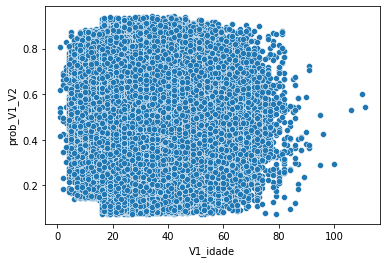

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.scatterplot(data=data_train, x = 'V1_idade', y = 'prob_V1_V2')

plt.show()

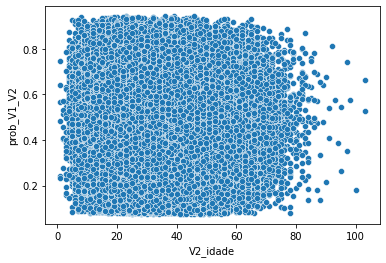

In [16]:
sns.scatterplot(data=data_train, x = 'V2_idade', y = 'prob_V1_V2')

plt.show()

Não é possível encontrar uma correlação bem estabelecida entre faixa etária com as taxas de contaminação. Quando isso acontece, uma boa forma de se obter insights sobre as features é através da discretização. Poderíamos fazer essa discrtização por faixas etárias homogêneas, por faixas de percentis ou mesmo por abordagens de clusterização não supervisionadas. Porém, como a idade é uma variável que temos intuição bastante grande, podemos utilizar as definições comumente usadas, como a discretização por gerações, por exemplo:

In [22]:
from functools import reduce

generation_discretizer = {
    "silent": [78,np.inf],
    "baby_boomer": [58, 78],
    "gen_x": [43, 58],
    "gen_y": [27, 43],
    "gen_z": [13, 27],
    "gen_alpha": [0, 13],
}


bins = sorted([0] + [elem[1] for elem in generation_discretizer.values()])

data_train_temp["V1_geracao"] = pd.cut(
    data_train_temp["V1_idade"], bins=bins, right=False, labels=generation_discretizer.keys()
)

data_train_temp["V2_geracao"] = pd.cut(
    data_train_temp["V2_idade"], bins=bins, right=False, labels=generation_discretizer.keys()
)

In [40]:
display(
    data_train_temp
    .assign(V1_geracao = data_train_temp['V1_geracao'].astype(str).replace('nan','nao_informado'))
    .assign(V2_geracao = data_train_temp['V2_geracao'].astype(str).replace('nan','nao_informado'))
    .groupby(
        ["V1_geracao", "V2_geracao"]
    ).agg(
        pct_mean=("prob_V1_V2", "mean"),
        pct_std=("prob_V1_V2", "std"),
        pct_median=("prob_V1_V2", "median"),
    )
)


pct_mean   pct_std  pct_median
V1_geracao    V2_geracao                                   
baby_boomer   baby_boomer    0.491831  0.173139    0.493135
              gen_alpha      0.514353  0.175265    0.528055
              gen_x          0.487055  0.173753    0.488520
              gen_y          0.481876  0.173347    0.481476
              gen_z          0.487307  0.176644    0.484231
              nao_informado  0.487908  0.174747    0.489801
              silent         0.495622  0.176834    0.497616
gen_alpha     baby_boomer    0.514612  0.194361    0.532553
              gen_x          0.462384  0.188428    0.448804
              gen_y          0.480332  0.157042    0.496935
              gen_z          0.450866  0.190692    0.450866
              nao_informado  0.389720  0.169973    0.381664
              silent         0.494779  0.222878    0.402313
gen_x         baby_boomer    0.482459  0.173633    0.484051
              gen_alpha      0.480163  0.171974    0.472877
              gen_x          0.478722  0.174226    0.479181
              gen_y          0.473083  0.173497    0.469657
              gen_z          0.470021  0.171291    0.469531
              nao_informado  0.480026  0.173130    0.478892
              silent         0.485986  0.174858    0.486864
gen_y         baby_boomer    0.483291  0.171509    0.485777
              gen_alpha      0.482050  0.173795    0.489072
              gen_x          0.480148  0.174808    0.479883
              gen_y          0.471769  0.175919    0.472277
              gen_z          0.473129  0.173708    0.469984
              nao_informado  0.479470  0.172991    0.478767
              silent         0.487681  0.169030    0.494402
gen_z         baby_boomer    0.481624  0.177666    0.477101
              gen_alpha      0.533483  0.304757    0.697203
              gen_x          0.476265  0.174166    0.475949
              gen_y          0.477240  0.175073    0.469288
              gen_z          0.464705  0.170478    0.469952
              nao_informado  0.467322  0.166930    0.472825
              silent         0.498789  0.161912    0.484914
nao_informado baby_boomer    0.488053  0.173926    0.489709
              gen_alpha      0.487395  0.186732    0.489780
              gen_x          0.484789  0.175472    0.485427
              gen_y          0.481688  0.175394    0.478852
              gen_z          0.488566  0.179484    0.483466
              nao_informado  0.485327  0.176903    0.487817
              silent         0.497684  0.180678    0.503659
silent        baby_boomer    0.548226  0.158916    0.553866
              gen_alpha      0.501650  0.199624    0.465852
              gen_x          0.544868  0.161055    0.550154
              gen_y          0.536071  0.160596    0.543680
              gen_z          0.551587  0.154941    0.551943
              nao_informado  0.544750  0.158975    0.553340
              silent         0.562359  0.163709    0.566342

**Observação**

Sob essa ótica, podemos ter alguns insights interessantes. Por exemplo, podemos verificar que a média da taxa de transmissão entre pessoas da geração `silent` (56%) é significativamente maior que a média da taxa entre pessoas da geração `Z` (47%). Dessa forma, as etapas de preprocessamento para a faixa etária serão:

* Passo 3: discretizar a coluna `V1_idade` pela faixa geracional, criando `V1_geracao`
* Passo 4: imputar o valor mais frequente na feature `V1_geracao`
* Passo 5: discretizar a coluna `V2_idade` pela faixa geracional, criando `V2_geracao`
* Passo 6: imputar o valor mais frequente na feature `V2_geracao`

---
## Estado Civil - Infectante

In [119]:
# Valores únicos
print("Classes = ",data_train_temp['V1_estado_civil'].unique())

# Quantidade de valores faltantes
print('NaN (%) = {:.2f}'.format(data_train_temp['V1_estado_civil'].isna().mean()))


data_train_temp['V1_estado_civil'] = data_train_temp['V1_estado_civil'].fillna('nao_informado')

data_train_temp['V1_estado_civil'].fillna('nao_informado').value_counts(normalize=True)

Classes =  ['solteiro' 'casado' 'divorciado' 'viuvo' 'nao_informado']
NaN (%) = 0.00


solteiro         0.421606
casado           0.265022
divorciado       0.176062
viuvo            0.087363
nao_informado    0.049947
Name: V1_estado_civil, dtype: float64

In [120]:
data_train_temp.groupby(
    "V1_estado_civil"
).agg(
    pct_mean=("prob_V1_V2", "mean"),
    pct_std=("prob_V1_V2", "std"),
    pct_median=("prob_V1_V2", "median"),
)

,pct_mean,pct_std,pct_median
V1_estado_civil,,,
casado,0.520043,0.152245,0.525031
divorciado,0.522295,0.192131,0.519423
nao_informado,0.485394,0.174795,0.485745
solteiro,0.468857,0.172331,0.470436
viuvo,0.384869,0.153249,0.373600


In [121]:
tukey = pairwise_tukeyhsd(
    endog=data_train_temp["prob_V1_V2"],
    groups=data_train_temp["V1_estado_civil"],
    alpha=0.01,
)
print(tukey)

       Multiple Comparison of Means - Tukey HSD, FWER=0.01        
    group1        group2    meandiff p-adj   lower   upper  reject
------------------------------------------------------------------
       casado    divorciado   0.0023 0.0624 -0.0005   0.005  False
       casado nao_informado  -0.0346  0.001  -0.039 -0.0303   True
       casado      solteiro  -0.0512  0.001 -0.0534  -0.049   True
       casado         viuvo  -0.1352  0.001 -0.1387 -0.1317   True
   divorciado nao_informado  -0.0369  0.001 -0.0415 -0.0323   True
   divorciado      solteiro  -0.0534  0.001  -0.056 -0.0509   True
   divorciado         viuvo  -0.1374  0.001 -0.1412 -0.1337   True
nao_informado      solteiro  -0.0165  0.001 -0.0208 -0.0123   True
nao_informado         viuvo  -0.1005  0.001 -0.1056 -0.0955   True
     solteiro         viuvo   -0.084  0.001 -0.0873 -0.0806   True
------------------------------------------------------------------


**Observação**

Com exceção das classes de casado e divorciado, todos as categorias apresentam média de taxa de contaminação distintas. Dessa forma, vou unificar as categorias de casado e divorciado e realizar um one-hot-encode, eliminando uma das categorias pra evitar multicolinearidade

* Passo 7: aplicar a imputação de `nao_informado` nos faltantes de  `V1_estado_civil`
* Passo 8: criar classe `casado_ou_divorciado`
* Passo 9: aplicar one-hot-encode à `V1_estado_civil` com exclusão de uma classe


---
## Estado Civil - Infectado

In [21]:
# Valores únicos
print("Classes = ",data_train_temp['V2_estado_civil'].unique())

# Quantidade de valores faltantes
print('NaN (%) = {:.2f}'.format(data_train_temp['V2_estado_civil'].isna().mean()))


data_train_temp['V2_estado_civil'] = data_train_temp['V2_estado_civil'].fillna('nao_informado')

#
data_train_temp['V2_estado_civil'].value_counts(normalize=True)

Classes =  ['viuvo' 'solteiro' 'casado' nan 'divorciado']
NaN (%) = 0.05


solteiro         0.419900
casado           0.265345
divorciado       0.176838
viuvo            0.088006
nao_informado    0.049912
Name: V2_estado_civil, dtype: float64

In [22]:
data_train_temp.groupby(
    "V2_estado_civil"
).agg(
    pct_mean=("prob_V1_V2", "mean"),
    pct_std=("prob_V1_V2", "std"),
    pct_median=("prob_V1_V2", "median"),
)

,pct_mean,pct_std,pct_median
V2_estado_civil,,,
casado,0.484173,0.174265,0.485511
divorciado,0.485004,0.173910,0.486443
nao_informado,0.487634,0.174045,0.487840
solteiro,0.485941,0.174128,0.487317
viuvo,0.485130,0.173392,0.485616


In [23]:
tukey = pairwise_tukeyhsd(
    endog=data_train_temp["prob_V1_V2"],
    groups=data_train_temp["V2_estado_civil"],
    alpha=0.01,
)
print(tukey)

       Multiple Comparison of Means - Tukey HSD, FWER=0.01       
    group1        group2    meandiff p-adj   lower  upper  reject
-----------------------------------------------------------------
       casado    divorciado   0.0008 0.8648  -0.002 0.0037  False
       casado nao_informado   0.0035 0.0912 -0.0011  0.008  False
       casado      solteiro   0.0018 0.0883 -0.0005 0.0041  False
       casado         viuvo    0.001    0.9 -0.0026 0.0046  False
   divorciado nao_informado   0.0026  0.359 -0.0021 0.0073  False
   divorciado      solteiro   0.0009 0.7449 -0.0017 0.0036  False
   divorciado         viuvo   0.0001    0.9 -0.0037 0.0039  False
nao_informado      solteiro  -0.0017 0.6914 -0.0061 0.0027  False
nao_informado         viuvo  -0.0025 0.5128 -0.0077 0.0027  False
     solteiro         viuvo  -0.0008    0.9 -0.0042 0.0026  False
-----------------------------------------------------------------


**Observação**

Nesse caso, não existe nenhuma diferença significativa de médias ocorre entre as categorias casado e solteiro. Se olharmos o valor médio e o desvio padrão das taxas em todas as categorias, conclui-se que o estado civil do infectado é uma feature de muito baixa aderência. Por conta disso, vamos desconsiderá-la na modelagem.

* Passo 10: remover coluna `V2_estado_civil`

---
## Quantidade de Filhos do Infectante

In [91]:
# Valores únicos
print("Classes = ",data_train_temp['V1_qt_filhos'].unique())

# Quantidade de valores faltantes
print('NaN (%) = {:.2f}'.format(data_train_temp['V1_qt_filhos'].isna().mean()))


#data_train_temp['V2_estado_civil'] = data_train_temp['V1_qt_filhos'].fillna('nao_informado')

#
data_train_temp['V1_qt_filhos'].value_counts(normalize=True)

Classes =  [ 2.  0.  1.  3. nan  5.  6.  4.  7.  8.]
NaN (%) = 0.03


0.0    0.413605
1.0    0.340988
2.0    0.170641
3.0    0.057182
4.0    0.014238
5.0    0.002777
6.0    0.000503
7.0    0.000058
8.0    0.000008
Name: V1_qt_filhos, dtype: float64

In [65]:
temp = data_train_temp[data_train_temp["V1_qt_filhos"].notna()]

tukey = pairwise_tukeyhsd(
    endog=temp["prob_V1_V2"],
    groups=temp["V1_qt_filhos"],
    alpha=0.05,
)
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0  -0.0106  0.001 -0.0127 -0.0085   True
   0.0    2.0  -0.0106  0.001 -0.0132 -0.0081   True
   0.0    3.0  -0.0107  0.001 -0.0147 -0.0068   True
   0.0    4.0  -0.0085 0.0157 -0.0161 -0.0009   True
   0.0    5.0  -0.0105 0.5859 -0.0275  0.0065  False
   0.0    6.0  -0.0193 0.8386 -0.0592  0.0205  False
   0.0    7.0  -0.0168    0.9 -0.1345  0.1008  False
   0.0    8.0   0.1558  0.808 -0.1553   0.467  False
   1.0    2.0  -0.0001    0.9 -0.0027  0.0026  False
   1.0    3.0  -0.0002    0.9 -0.0042  0.0039  False
   1.0    4.0   0.0021    0.9 -0.0056  0.0097  False
   1.0    5.0   0.0001    0.9  -0.017  0.0171  False
   1.0    6.0  -0.0087    0.9 -0.0486  0.0311  False
   1.0    7.0  -0.0063    0.9 -0.1239  0.1114  False
   1.0    8.0   0.1664  0.744 -0.1447  0.4776  False
   2.0    3.0  -0.0001    0.9 -0.0044  0.0042 

**Observações**

Vemos que as únicas diferenciações nas médias entre taxas de contaminação estão entre infectantes sem filhos para com infectantes com 1,2, 3 ou 4 filhos. Vamos testar a criação de uma flag de filhos do infectante

In [66]:
data_train_temp["V1_tem_filhos"] = np.where(data_train_temp["V1_qt_filhos"] > 0, 1, data_train_temp["V1_qt_filhos"])

,pct_mean,pct_std,pct_median
V1_tem_filhos,,,
0.0,0.491371,0.173369,0.493574
1.0,0.480801,0.174036,0.481515


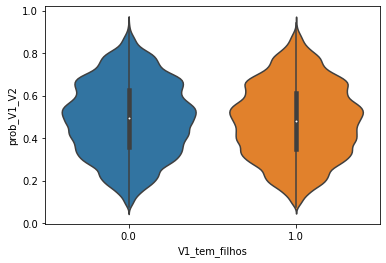

In [73]:
display(
    data_train_temp.groupby(
        "V1_tem_filhos"
    ).agg(
        pct_mean=("prob_V1_V2", "mean"),
        pct_std=("prob_V1_V2", "std"),
        pct_median=("prob_V1_V2", "median"),
    )
)

sns.violinplot(x="V1_tem_filhos", y="prob_V1_V2", data=data_train_temp)
plt.show()

Aparentemente, pessoas sem filhos tem uma taxa de contaminação ligeiramente maior; porém, a diferença da taxa de contaminação entre infectantes com e sem filhos é bastante pequena. Vamos confirmar estatisticamente se essa diferença é significativa

In [80]:
tukey = pairwise_tukeyhsd(
    endog=data_train_temp["prob_V1_V2"],
    groups=data_train_temp["V1_tem_filhos"].astype(str).replace('nan','nao_informado'),
    alpha=0.05,
)
print(tukey)

    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
group1     group2    meandiff p-adj   lower   upper  reject
-----------------------------------------------------------
   0.0           1.0  -0.0106  0.001 -0.0119 -0.0092   True
   0.0 nao_informado  -0.0059 0.0017 -0.0099 -0.0019   True
   1.0 nao_informado   0.0047 0.0167  0.0007  0.0087   True
-----------------------------------------------------------


In [82]:
data_train_temp["V1_tem_filhos"].value_counts(normalize=True)

1.0    0.586395
0.0    0.413605
Name: V1_tem_filhos, dtype: float64

**Observações**

Assim, com o teste Tukey, podemos confirmar que a diferença entre a taxa de contaminação entre infectantes com e sem filhos é significativa.

* Passo 11: criar variável dummy para categoria `V1_tem_filhos` a partir da coluna `V1_qt_filhos`
* Passo 12: preencher valores faltantes com a moda `V2_estado_civil`

---
## Quantidade de Filhos do Infectado

In [92]:
# Valores únicos
print("Classes = ",data_train_temp['V2_qt_filhos'].unique())

# Quantidade de valores faltantes
print('NaN (%) = {:.2f}'.format(data_train_temp['V2_qt_filhos'].isna().mean()))


#data_train_temp['V2_estado_civil'] = data_train_temp['V1_qt_filhos'].fillna('nao_informado')

#
data_train_temp['V2_qt_filhos'].value_counts(normalize=True)

Classes =  [ 0.  1.  2.  3.  5. nan  4.  6.  7.  8.]
NaN (%) = 0.03


0.0    0.412517
1.0    0.341181
2.0    0.172080
3.0    0.056753
4.0    0.014122
5.0    0.002754
6.0    0.000538
7.0    0.000049
8.0    0.000005
Name: V2_qt_filhos, dtype: float64

In [83]:
temp = data_train_temp[data_train_temp["V2_qt_filhos"].notna()]

tukey = pairwise_tukeyhsd(
    endog=temp["prob_V1_V2"],
    groups=temp["V2_qt_filhos"],
    alpha=0.05,
)
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0  -0.0014 0.5073 -0.0034 0.0007  False
   0.0    2.0  -0.0012 0.8676 -0.0038 0.0014  False
   0.0    3.0  -0.0029 0.3523 -0.0069 0.0011  False
   0.0    4.0  -0.0008    0.9 -0.0084 0.0069  False
   0.0    5.0  -0.0055    0.9 -0.0225 0.0116  False
   0.0    6.0  -0.0054    0.9 -0.0439 0.0332  False
   0.0    7.0   0.0143    0.9 -0.1128 0.1415  False
   0.0    8.0   0.0911    0.9 -0.2902 0.4725  False
   1.0    2.0   0.0002    0.9 -0.0025 0.0028  False
   1.0    3.0  -0.0016    0.9 -0.0056 0.0025  False
   1.0    4.0   0.0006    0.9 -0.0071 0.0083  False
   1.0    5.0  -0.0041    0.9 -0.0212  0.013  False
   1.0    6.0   -0.004    0.9 -0.0426 0.0345  False
   1.0    7.0   0.0157    0.9 -0.1114 0.1428  False
   1.0    8.0   0.0925    0.9 -0.2888 0.4738  False
   2.0    3.0  -0.0017    0.9 -0.0061 0.0026  False
   2.0    4.

**Observações**
 
Com o teste Tukey, podemos confirmar que não existe diferença entre a taxa de contaminação dos infectados pelo número de filhos. Por isso, podemos inferir que essa não é uma feature aderente.

* Passo 13: excluir coluna `V2_qt_filhos`

---
## Infectante Estuda?

In [94]:
# Valores únicos
print("Classes = ",data_train_temp['V1_estuda'].unique())

# Quantidade de valores faltantes
print('NaN (%) = {:.2f}'.format(data_train_temp['V1_estuda'].isna().mean()))


#data_train_temp['V2_estado_civil'] = data_train_temp['V1_qt_filhos'].fillna('nao_informado')

#
data_train_temp['V1_estuda'].value_counts(normalize=True)

Classes =  [ 0.  1. nan]
NaN (%) = 0.04


0.0    0.557842
1.0    0.442158
Name: V1_estuda, dtype: float64

,pct_mean,pct_std,pct_median
V1_estuda,,,
0.0,0.471101,0.173137,0.470516
1.0,0.502790,0.173048,0.506551


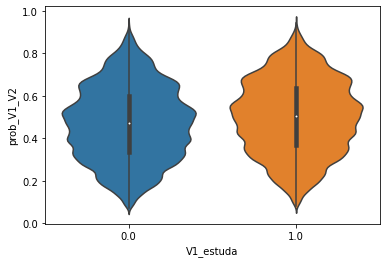

In [88]:
display(
    data_train_temp.groupby(
        "V1_estuda"
    ).agg(
        pct_mean=("prob_V1_V2", "mean"),
        pct_std=("prob_V1_V2", "std"),
        pct_median=("prob_V1_V2", "median"),
    )
)


sns.violinplot(x="V1_estuda", y="prob_V1_V2", data=data_train_temp)
plt.show()

In [89]:
temp = data_train_temp[data_train_temp["V1_estuda"].notna()]

tukey = pairwise_tukeyhsd(
    endog=temp["prob_V1_V2"],
    groups=temp["V1_estuda"],
    alpha=0.05,
)
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
   0.0    1.0   0.0317 0.001 0.0306 0.0328   True
-------------------------------------------------


**Observações**

Pode-se afirmar com nível de significância de $95\%$ que infectantes que estudam tem taxa de contaminação diferente dos infectantes que não estudam.


* Passo 14: preencher valores fantantes da coluna `V1_estuda` com o valor mais frequente

---
## Infectado Estuda?

In [95]:
# Valores únicos
print("Classes = ",data_train_temp['V2_estuda'].unique())

# Quantidade de valores faltantes
print('NaN (%) = {:.2f}'.format(data_train_temp['V2_estuda'].isna().mean()))


#data_train_temp['V2_estado_civil'] = data_train_temp['V1_qt_filhos'].fillna('nao_informado')

#
data_train_temp['V2_estuda'].value_counts(normalize=True)

Classes =  [nan  0.  1.]
NaN (%) = 0.04


0.0    0.557275
1.0    0.442725
Name: V2_estuda, dtype: float64

,pct_mean,pct_std,pct_median
V2_estuda,,,
0.0,0.484619,0.173657,0.485971
1.0,0.485978,0.173928,0.487330


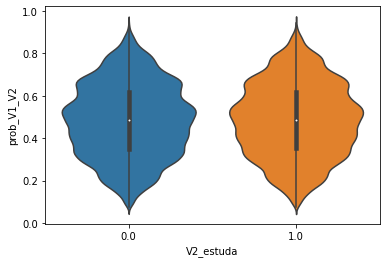

In [96]:
display(
    data_train_temp.groupby(
        "V2_estuda"
    ).agg(
        pct_mean=("prob_V1_V2", "mean"),
        pct_std=("prob_V1_V2", "std"),
        pct_median=("prob_V1_V2", "median"),
    )
)


sns.violinplot(x="V2_estuda", y="prob_V1_V2", data=data_train_temp)
plt.show()

In [99]:
temp = data_train_temp[data_train_temp["V2_estuda"].notna()]

tukey = pairwise_tukeyhsd(
    endog=temp["prob_V1_V2"],
    groups=temp["V2_estuda"],
    alpha=0.01,
)
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.01
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   0.0014 0.0198 -0.0001 0.0029  False
---------------------------------------------------


**Observações**

Pelo teste de Tukey, podemos afirmar com nível de significância de $99\%$ que infectados que estudam tem taxa de contaminação igual a dos inefectados que não estudam. Dessa forma, podemos tomar esse fato como um indicativo de que a feature `V2_estuda` não é aderente.

* Passo 15: desconsiderar a coluna `V2_estuda`

---
## Infectante Trabalha?

In [25]:
# Valores únicos
print("Classes = ",data_train_temp['V1_trabalha'].unique())

# Quantidade de valores faltantes
print('NaN (%) = {:.2f}'.format(data_train_temp['V1_trabalha'].isna().mean()))


#data_train_temp['V2_estado_civil'] = data_train_temp['V1_qt_filhos'].fillna('nao_informado')

#
data_train_temp['V1_trabalha'].value_counts(normalize=True)

Classes =  [ 0.  1. nan]
NaN (%) = 0.01


1.0    0.556987
0.0    0.443013
Name: V1_trabalha, dtype: float64

,pct_mean,pct_std,pct_median
V1_trabalha,,,
0.0,0.557858,0.162604,0.566510
1.0,0.427553,0.160776,0.420169


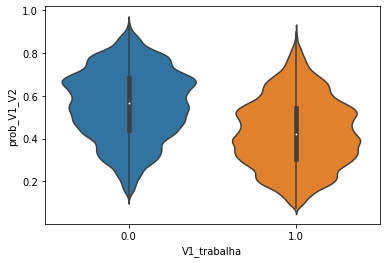

In [26]:
display(
    data_train_temp.groupby(
        "V1_trabalha"
    ).agg(
        pct_mean=("prob_V1_V2", "mean"),
        pct_std=("prob_V1_V2", "std"),
        pct_median=("prob_V1_V2", "median"),
    )
)


sns.violinplot(x="V1_trabalha", y="prob_V1_V2", data=data_train_temp)
plt.show()

In [27]:
temp = data_train_temp[data_train_temp["V1_trabalha"].notna()]

tukey = pairwise_tukeyhsd(
    endog=temp["prob_V1_V2"],
    groups=temp["V1_trabalha"],
    alpha=0.01,
)
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.01
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
   0.0    1.0  -0.1303 0.001 -0.1317 -0.1289   True
---------------------------------------------------


**Observações**

Vamos aqui que, com $99\%$ de confiança, infectantes que não trabalham tem média de taxa de contaminação maior que os infectantes que trabalham. Assim, a única etapa de preprocessamento aqui será a de imputação de dados faltantes com valor mais frequente

* Passo 16: preencher valores fantantes da coluna `V1_trabalha` com o valor mais frequente

---
## Infectado Trabalha?

In [28]:
# Valores únicos
print("Classes = ",data_train_temp['V2_trabalha'].unique())

# Quantidade de valores faltantes
print('NaN (%) = {:.2f}'.format(data_train_temp['V2_trabalha'].isna().mean()))


#data_train_temp['V2_estado_civil'] = data_train_temp['V1_qt_filhos'].fillna('nao_informado')

#
data_train_temp['V2_trabalha'].value_counts(normalize=True)

Classes =  [ 1.  0. nan]
NaN (%) = 0.01


1.0    0.557355
0.0    0.442645
Name: V2_trabalha, dtype: float64

,pct_mean,pct_std,pct_median
V2_trabalha,,,
0.0,0.486024,0.174026,0.487431
1.0,0.484724,0.174100,0.485838


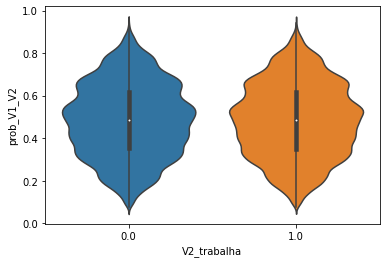

In [29]:
display(
    data_train_temp.groupby(
        "V2_trabalha"
    ).agg(
        pct_mean=("prob_V1_V2", "mean"),
        pct_std=("prob_V1_V2", "std"),
        pct_median=("prob_V1_V2", "median"),
    )
)


sns.violinplot(x="V2_trabalha", y="prob_V1_V2", data=data_train_temp)
plt.show()

In [30]:
temp = data_train_temp[data_train_temp["V2_trabalha"].notna()]

tukey = pairwise_tukeyhsd(
    endog=temp["prob_V1_V2"],
    groups=temp["V2_trabalha"],
    alpha=0.01,
)
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.01
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0  -0.0013 0.0235 -0.0028 0.0002  False
---------------------------------------------------


**Observações**

Pelo teste de Tukey, podemos afirmar com nível de significância de $99\%$ que infectados que trabalham tem taxa de contaminação igual a dos inefectados que não trabalham. Dessa forma, podemos tomar esse fato como um indicativo de que a feature `V2_trabalha` não é aderente.

* Passo 17: desconsiderar a coluna `V2_trabalha`

---
## Infectante Pratica Esportes?

In [49]:
# Valores únicos
print("Classes = ", data_train_temp["V1_pratica_esportes"].unique())

# Quantidade de valores faltantes
print("NaN (%) = {:.3f}".format(data_train_temp["V1_pratica_esportes"].isna().mean()))


# data_train_temp['V2_estado_civil'] = data_train_temp['V1_qt_filhos'].fillna('nao_informado')

#
data_train_temp["V1_pratica_esportes"].replace({0: "nao", 1: "sim"}).fillna(
    "nao_informado"
).value_counts(normalize=True)

Classes =  [nan  1.  0.]
NaN (%) = 0.149


sim              0.510279
nao              0.340614
nao_informado    0.149107
Name: V1_pratica_esportes, dtype: float64

,pct_mean,pct_std,pct_median
V1_pratica_esportes,,,
0.0,0.410644,0.160811,0.399372
1.0,0.534993,0.164659,0.539016


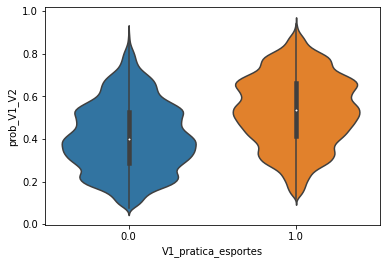

In [32]:
display(
    data_train_temp.groupby(
        "V1_pratica_esportes"
    ).agg(
        pct_mean=("prob_V1_V2", "mean"),
        pct_std=("prob_V1_V2", "std"),
        pct_median=("prob_V1_V2", "median"),
    )
)


sns.violinplot(x="V1_pratica_esportes", y="prob_V1_V2", data=data_train_temp)
plt.show()

In [33]:
temp = data_train_temp[data_train_temp["V1_pratica_esportes"].notna()]

tukey = pairwise_tukeyhsd(
    endog=temp["prob_V1_V2"],
    groups=temp["V1_pratica_esportes"],
    alpha=0.01,
)
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.01
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
   0.0    1.0   0.1243 0.001 0.1228 0.1259   True
-------------------------------------------------


**Observações**

Vamos aqui que, com $99\%$ de confiança, infectantes que não praticam esportes tem média de taxa de contaminação menor que os infectantes que praticam esportes. Assim, a única etapa de preprocessamento aqui será a de imputação de dados faltantes com valor mais frequente

* Passo 18: preencher valores fantantes da coluna `V1_pratica_esportes` com o valor mais frequente

---
## Infectado Pratica Esportes?

In [34]:
# Valores únicos
print("Classes = ",data_train_temp['V2_pratica_esportes'].unique())

# Quantidade de valores faltantes
print('NaN (%) = {:.2f}'.format(data_train_temp['V2_pratica_esportes'].isna().mean()))


#data_train_temp['V2_estado_civil'] = data_train_temp['V1_qt_filhos'].fillna('nao_informado')

#
data_train_temp['V2_pratica_esportes'].value_counts(normalize=True)

Classes =  [ 1.  0. nan]
NaN (%) = 0.15


1.0    0.601277
0.0    0.398723
Name: V2_pratica_esportes, dtype: float64

,pct_mean,pct_std,pct_median
V2_pratica_esportes,,,
0.0,0.485499,0.173971,0.485665
1.0,0.484895,0.174004,0.486527


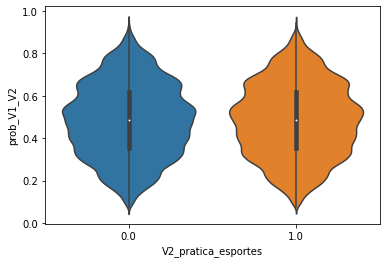

In [35]:
display(
    data_train_temp.groupby(
        "V2_pratica_esportes"
    ).agg(
        pct_mean=("prob_V1_V2", "mean"),
        pct_std=("prob_V1_V2", "std"),
        pct_median=("prob_V1_V2", "median"),
    )
)


sns.violinplot(x="V2_pratica_esportes", y="prob_V1_V2", data=data_train_temp)
plt.show()

In [36]:
temp = data_train_temp[data_train_temp["V2_pratica_esportes"].notna()]

tukey = pairwise_tukeyhsd(
    endog=temp["prob_V1_V2"],
    groups=temp["V2_pratica_esportes"],
    alpha=0.01,
)
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.01
group1 group2 meandiff p-adj   lower  upper reject
--------------------------------------------------
   0.0    1.0  -0.0006 0.3363 -0.0022 0.001  False
--------------------------------------------------


**Observações**

Vamos aqui que, com $99\%$ de confiança, infectados que não praticam esportes tem média de taxa de contaminação igual que os infectados que praticam esportes. Assim, conclui-se que essa não é uma feature aderente

* Passo 19: negligenciar a coluna `V2_pratica_esportes`

---
## Transporte mais utilizado pelo infectante

In [37]:
# Valores únicos
print("Classes = ",data_train_temp['V1_transporte_mais_utilizado'].unique())

# Quantidade de valores faltantes
print('NaN (%) = {:.2f}'.format(data_train_temp['V1_transporte_mais_utilizado'].isna().mean()))


#data_train_temp['V2_estado_civil'] = data_train_temp['V1_qt_filhos'].fillna('nao_informado')

#
data_train_temp['V1_transporte_mais_utilizado'].value_counts(normalize=True)

Classes =  ['publico' 'particular' 'taxi' nan]
NaN (%) = 0.04


publico       0.600550
particular    0.349924
taxi          0.049525
Name: V1_transporte_mais_utilizado, dtype: float64

,pct_mean,pct_std,pct_median
V1_transporte_mais_utilizado,,,
particular,0.475635,0.193578,0.464050
publico,0.495952,0.161397,0.502126
taxi,0.426382,0.160277,0.417530


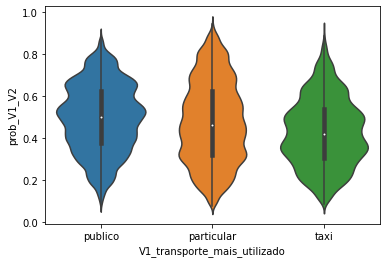

In [38]:
display(
    data_train_temp.groupby(
        "V1_transporte_mais_utilizado"
    ).agg(
        pct_mean=("prob_V1_V2", "mean"),
        pct_std=("prob_V1_V2", "std"),
        pct_median=("prob_V1_V2", "median"),
    )
)


sns.violinplot(x="V1_transporte_mais_utilizado", y="prob_V1_V2", data=data_train_temp)
plt.show()

In [39]:
temp = data_train_temp[data_train_temp["V1_transporte_mais_utilizado"].notna()]

tukey = pairwise_tukeyhsd(
    endog=temp["prob_V1_V2"],
    groups=temp["V1_transporte_mais_utilizado"],
    alpha=0.01,
)
print(tukey)

  Multiple Comparison of Means - Tukey HSD, FWER=0.01   
  group1    group2 meandiff p-adj  lower   upper  reject
--------------------------------------------------------
particular publico   0.0203 0.001  0.0185  0.0221   True
particular    taxi  -0.0493 0.001 -0.0533 -0.0452   True
   publico    taxi  -0.0696 0.001 -0.0735 -0.0656   True
--------------------------------------------------------


**Observações**

Pelo teste de Tukey, verifica-se que a média de taxa de contaminação de acordo com a forma de transporte mais utilizado é diferente entre todos as categorias.

* Transporte público é o meio de transporte dentro os infectantes com maior média na taxa de infecção
* Taxi é o meio de transporte dentro os infectantes com menor média na taxa de infecção

O método mais adequado para esse caso é o one-hot-encode, lembrando que negligenciar uma das categorias pra evitar multicolinearidade


* Passo 20: subsituit valores fantantes da coluna `V1_transporte_mais_utilizado` pela moda
* Passo 21: aplicar one-hot-encode na coluna `V1_transporte_mais_utilizado` excluindo uma categoria

---
## Transporte mais utilizado pelo infectado

In [40]:
# Valores únicos
print("Classes = ",data_train_temp['V2_transporte_mais_utilizado'].unique())

# Quantidade de valores faltantes
print('NaN (%) = {:.2f}'.format(data_train_temp['V2_transporte_mais_utilizado'].isna().mean()))


#data_train_temp['V2_estado_civil'] = data_train_temp['V1_qt_filhos'].fillna('nao_informado')

#
data_train_temp['V2_transporte_mais_utilizado'].value_counts(normalize=True)

Classes =  ['particular' 'publico' 'taxi' nan]
NaN (%) = 0.04


publico       0.599918
particular    0.349711
taxi          0.050371
Name: V2_transporte_mais_utilizado, dtype: float64

,pct_mean,pct_std,pct_median
V2_transporte_mais_utilizado,,,
particular,0.552992,0.167164,0.564461
publico,0.447352,0.166297,0.444342
taxi,0.466710,0.168828,0.466736


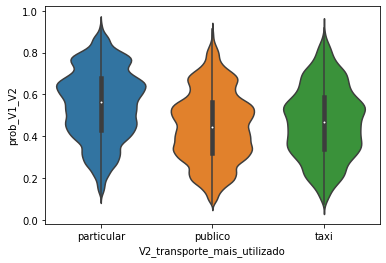

In [50]:
display(
    data_train_temp.groupby(
        "V2_transporte_mais_utilizado"
    ).agg(
        pct_mean=("prob_V1_V2", "mean"),
        pct_std=("prob_V1_V2", "std"),
        pct_median=("prob_V1_V2", "median"),
    )
)


sns.violinplot(x="V2_transporte_mais_utilizado", y="prob_V1_V2", data=data_train_temp)
plt.show()

In [51]:
temp = data_train_temp[data_train_temp["V2_transporte_mais_utilizado"].notna()]

tukey = pairwise_tukeyhsd(
    endog=temp["prob_V1_V2"],
    groups=temp["V2_transporte_mais_utilizado"],
    alpha=0.01,
)
print(tukey)

  Multiple Comparison of Means - Tukey HSD, FWER=0.01   
  group1    group2 meandiff p-adj  lower   upper  reject
--------------------------------------------------------
particular publico  -0.1056 0.001 -0.1074 -0.1039   True
particular    taxi  -0.0863 0.001 -0.0901 -0.0824   True
   publico    taxi   0.0194 0.001  0.0156  0.0231   True
--------------------------------------------------------


**Observações**

Pelo teste de Tukey, verifica-se que a média de taxa de contaminação de acordo com a forma de transporte mais utilizado é diferente entre todos as categorias.

* Transporte particular é o meio de transporte dentro os infectados com maior média na taxa de infecção
* Transporte público é o meio de transporte dentro os infectantes com menor média na taxa de infecção

O método mais adequado para esse caso é o one-hot-encode, lembrando que negligenciar uma das categorias pra evitar multicolinearidade


* Passo 22: subsituir valores fantantes da coluna `V2_transporte_mais_utilizado` pela moda
* Passo 23: aplicar one-hot-encode na coluna `V2_transporte_mais_utilizado` excluindo uma categoria

---
## Cruzamento de meios de transporte infectantes x infectados

In [52]:
display(
    data_train_temp.groupby(
        ["V1_transporte_mais_utilizado", "V2_transporte_mais_utilizado"]
    ).agg(
        pct_mean=("prob_V1_V2", "mean"),
        pct_std=("prob_V1_V2", "std"),
        pct_median=("prob_V1_V2", "median"),
    )
)


# sns.violinplot(x="V2_transporte_mais_utilizado", y="prob_V1_V2", data=data_train_temp)
# plt.show()

pct_mean   pct_std  \
V1_transporte_mais_utilizado V2_transporte_mais_utilizado                       
particular                   particular                    0.540961  0.187723   
                             publico                       0.438532  0.186937   
                             taxi                          0.459409  0.190614   
publico                      particular                    0.564693  0.153329   
                             publico                       0.457499  0.153144   
                             taxi                          0.476477  0.153993   
taxi                         particular                    0.494602  0.156028   
                             publico                       0.389907  0.149398   
                             taxi                          0.398669  0.157012   

                                                           pct_median  
V1_transporte_mais_utilizado V2_transporte_mais_utilizado              
particular                   particular                      0.544063  
                             publico                         0.422631  
                             taxi                            0.449532  
publico                      particular                      0.580750  
                             publico                         0.462700  
                             taxi                            0.481904  
taxi                         particular                      0.490335  
                             publico                         0.375011  
                             taxi                            0.385157

---
## IMC do infectante

In [48]:
data_train_temp[['V1_IMC','prob_V1_V2']].corr()

,V1_IMC,prob_V1_V2
V1_IMC,1.000000,0.002343
prob_V1_V2,0.002343,1.000000


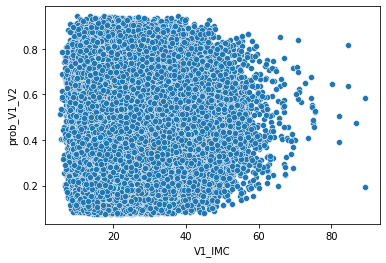

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.scatterplot(data=data_train, x = 'V1_IMC', y = 'prob_V1_V2')

plt.show()

Assim como no caso da idade, vemos uma correlação bastante baixa entre a variável explicativa e a variável resposta. Nesse caso, vamos novamente utilizar o procedimento de discretização para obtenção de insights sobre a variável

In [83]:
from functools import reduce

# World Health Organization
imc_discretizer = {
    "baixo_peso": [0, 18.5],
    "normal": [18.5, 25],
    "sobrepeso": [25, 30],
    "obeso_1": [30, 35],
    "obeso_2": [35, 40],
    "obeso_3": [40, np.inf],
}


bins = sorted([0] + [elem[1] for elem in imc_discretizer.values()])

data_train_temp["V1_IMC_disc"] = pd.cut(
    data_train_temp["V1_IMC"], bins=bins, right=False, labels=imc_discretizer.keys()
)

data_train_temp["V2_IMC_disc"] = pd.cut(
    data_train_temp["V2_IMC"], bins=bins, right=False, labels=imc_discretizer.keys()
)

In [84]:
display(
    data_train_temp.groupby(
        ["V1_IMC_disc", "V2_IMC_disc"]
    ).agg(
        pct_mean=("prob_V1_V2", "mean"),
        pct_std=("prob_V1_V2", "std"),
        pct_median=("prob_V1_V2", "median"),
    )
)


pct_mean   pct_std  pct_median
V1_IMC_disc V2_IMC_disc                                
baixo_peso  baixo_peso   0.479286  0.172918    0.480500
            normal       0.483365  0.174235    0.484968
            sobrepeso    0.487933  0.174044    0.490184
            obeso_1      0.492907  0.174469    0.495463
            obeso_2      0.499222  0.176632    0.499449
            obeso_3      0.503444  0.174442    0.505352
normal      baixo_peso   0.479953  0.172487    0.480435
            normal       0.484284  0.173781    0.484404
            sobrepeso    0.488783  0.175216    0.489229
            obeso_1      0.490783  0.174356    0.491307
            obeso_2      0.494599  0.170904    0.497871
            obeso_3      0.500309  0.174625    0.501095
sobrepeso   baixo_peso   0.480934  0.175347    0.480384
            normal       0.484586  0.174139    0.486457
            sobrepeso    0.490284  0.173547    0.491462
            obeso_1      0.493864  0.176435    0.496671
            obeso_2      0.506039  0.174015    0.507603
            obeso_3      0.505895  0.173547    0.514519
obeso_1     baixo_peso   0.478777  0.170945    0.481517
            normal       0.482170  0.173740    0.482003
            sobrepeso    0.485767  0.175229    0.489476
            obeso_1      0.500632  0.175091    0.500758
            obeso_2      0.502011  0.175867    0.505428
            obeso_3      0.505707  0.175177    0.504376
obeso_2     baixo_peso   0.482617  0.173559    0.482989
            normal       0.486428  0.174370    0.487307
            sobrepeso    0.492161  0.175010    0.497015
            obeso_1      0.498246  0.179486    0.497746
            obeso_2      0.481468  0.178412    0.483580
            obeso_3      0.525196  0.177640    0.518312
obeso_3     baixo_peso   0.482030  0.174632    0.484903
            normal       0.490988  0.172150    0.493600
            sobrepeso    0.492475  0.171754    0.497945
            obeso_1      0.506045  0.180791    0.518500
            obeso_2      0.514407  0.172783    0.522621
            obeso_3      0.494013  0.192674    0.483831

**Observação**

Mais uma vez, podemos ter um pouco mais de clareza sobre a relação entre a variável explicativa e a variável resposta. A médida da taxa de contaminação de pessoas de baixo peso por exemplo (que é de 48%) é significativamente mais baixa que a média da taxa de contaminação entre Obeso2-Obeso3 (que é de 52.5%). Assim, o procedimento de preprocessamento para variáveis de IMC serão: 


* Passo 24: discretizar a coluna `V1_IMC`, criando `V1_IMC_disc`
* Passo 25: imputar o valor mais frequente na feature `V1_IMC_disc`
* Passo 26: discretizar a coluna `V2_IMC`, criando `V2_IMC_disc`
* Passo 27: imputar o valor mais frequente na feature `V2_IMC_disc`